In [1]:
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import rasterio
from rasterio.features import rasterize
from osgeo import gdal
from matplotlib import pyplot as plt

In [3]:
# Needed only once to convert jp2 to netCDF
inputfile = 'D:/COPY/Projekt_FF/Data/dop10rgbi_32_468_5671_1_nw_2021.jp2'
outputfile = 'D:/COPY/Projekt_FF/Data/dop.nc'
ds = gdal.Translate(outputfile, inputfile, format='NetCDF')

In [3]:
# Needed only once to convert jp2 to netCDF
inputfile_train = 'D:/COPY/Projekt_FF/Data/dop10rgbi_32_468_5671_1_nw_2021.jp2'
outputfile_train = 'D:/COPY/Projekt_FF/Data/dop_train.nc'
ds = gdal.Translate(outputfile_train, inputfile_train, format='NetCDF')

inputfile_test = 'D:/COPY/Projekt_FF/Data/dop10rgbi_32_466_5670_1_nw_2021.jp2'
outputfile_test = 'D:/COPY/Projekt_FF/Data/dop_test.nc'
ds = gdal.Translate(outputfile_test, inputfile_test, format='NetCDF')

In [2]:
# Define file path to DOP tiles
filepath = 'D:/COPY/Projekt_FF/Data/'

# Read DOP files as xarray.Dataset
dop_train = rxr.open_rasterio(filepath + 'dop_train.nc')
dop_test = rxr.open_rasterio(filepath + 'dop_test.nc')

print(dop_train)
print(dop_test)

<xarray.Dataset>
Dimensions:              (band: 1, x: 10000, y: 10000)
Coordinates:
  * band                 (band) int32 1
  * x                    (x) float64 4.68e+05 4.68e+05 ... 4.69e+05 4.69e+05
  * y                    (y) float64 5.672e+06 5.672e+06 ... 5.671e+06 5.671e+06
    transverse_mercator  int32 0
Data variables:
    Band1                (band, y, x) uint8 ...
    Band2                (band, y, x) uint8 ...
    Band3                (band, y, x) uint8 ...
    Band4                (band, y, x) uint8 ...
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.5.3, released 2022/10/21
    history:      Fri Nov 11 15:58:37 2022: GDAL CreateCopy( D:/COPY/Projekt_...
<xarray.Dataset>
Dimensions:              (band: 1, x: 10000, y: 10000)
Coordinates:
  * band                 (band) int32 1
  * x                    (x) float64 4.66e+05 4.66e+05 ... 4.67e+05 4.67e+05
  * y                    (y) float64 5.671e+06 5.671e+06 ... 5.67e+06 5.67e+06
    transverse_mercator  in

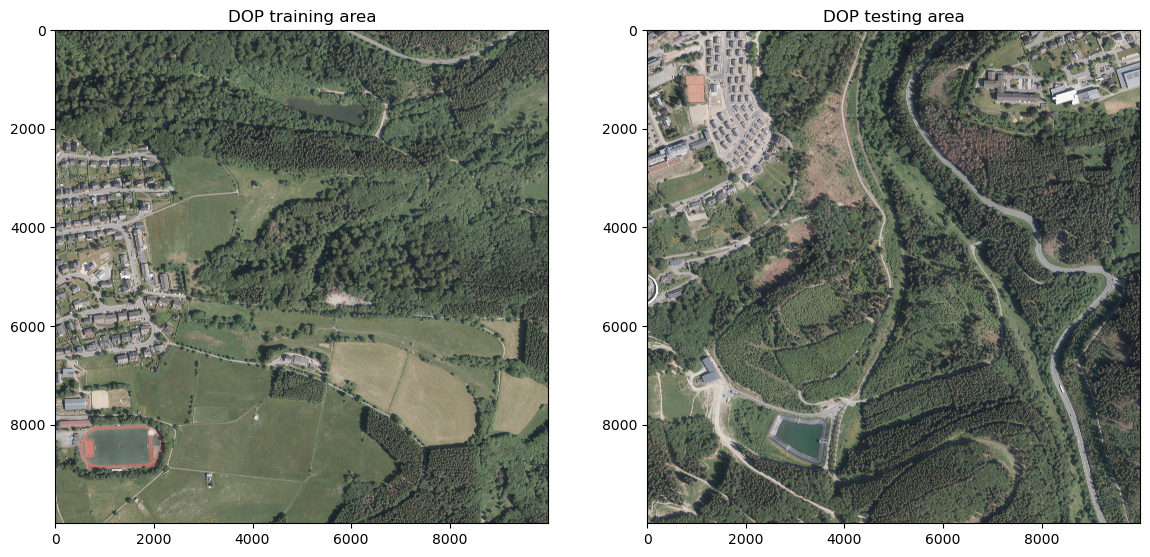

In [3]:
# Remove one dimension from the datasets
dop_train = dop_train.squeeze()
dop_test = dop_test.squeeze()

# Plot the DOPs
fig, ax = plt.subplots(1,2,figsize=(14,10))
ax[0].imshow(np.array([dop_train.Band1, dop_train.Band2, dop_train.Band3]).transpose(1,2,0))
ax[0].set_title('DOP training area')
ax[1].imshow(np.array([dop_test.Band1, dop_test.Band2, dop_test.Band3]).transpose(1,2,0))
ax[1].set_title('DOP testing area')
plt.show()

In [4]:
# Read polygons defined as 'forest' based on 'Basis DLM'
# They were pre extracted for the investigated DOP tiles
forest_polygons_train = gpd.read_file('D:/COPY/Projekt_FF/Data/forest_dop_train.gpkg')
forest_polygons_test = gpd.read_file('D:/COPY/Projekt_FF/Data/forest_dop_test.gpkg')

Text(0.5, 1.0, 'Test Polygons')

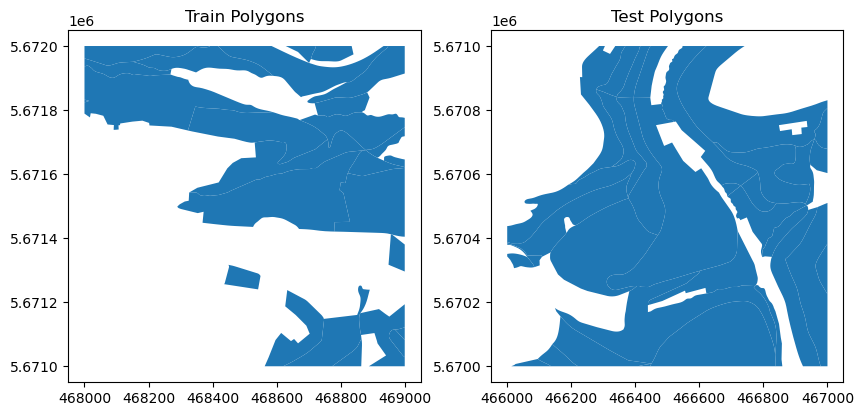

In [12]:
# Plot of the forest polygons
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,6))
forest_polygons_train.plot(ax=ax1)
ax1.set_title('Train Polygons')
forest_polygons_test.plot(ax=ax2)
ax2.set_title('Test Polygons')

In [13]:
# Create raster mask of the forest polygons
# which can be later used for training
# This mask will be filled with values 0 (non-forest) and 1 (forest)

# Get geometries of the polygons
geom_train = [shapes for shapes in forest_polygons_train.geometry]
geom_test = [shapes for shapes in forest_polygons_test.geometry]

# Get parameters of the DOPs needed for the mask
with rasterio.open('D:/COPY/Projekt_FF/Data/dop10rgbi_32_468_5671_1_nw_2021.jp2') as src:
    profile_train = src.profile
print(profile_train["transform"])
print(profile_train["crs"])
print(profile_train["width"])

with rasterio.open('D:/COPY/Projekt_FF/Data/dop10rgbi_32_466_5670_1_nw_2021.jp2') as src:
    profile_test = src.profile
print(profile_test["transform"])
print(profile_test["crs"])
print(profile_test["width"])

# Rasterize the polygons
trainmask = rasterize(geom_train, 
                      out_shape = (profile_train['width'], profile_train['height']),
                      fill=0,
                      transform=profile_train['transform'],
                      all_touched=True,
                      default_value=1)

testmask = rasterize(geom_test, 
                     out_shape = (profile_test['width'], profile_test['height']),
                     fill=0,
                     transform=profile_test['transform'],
                     all_touched=True,
                     default_value=1)

print(trainmask)
print(testmask)

| 0.10, 0.00, 468000.00|
| 0.00,-0.10, 5672000.00|
| 0.00, 0.00, 1.00|
EPSG:25832
10000
| 0.10, 0.00, 466000.00|
| 0.00,-0.10, 5671000.00|
| 0.00, 0.00, 1.00|
EPSG:25832
10000
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


In [14]:
# Add the mask (numpy-array) as new data variable to the DOPs xarray.Dataset
dop_train['forest_mask']=(['x', 'y'], trainmask)
dop_test['forest_mask']=(['x', 'y'], testmask)

print(dop_train)
print(dop_test)

<xarray.Dataset>
Dimensions:              (x: 10000, y: 10000)
Coordinates:
    band                 int32 1
  * x                    (x) float64 4.68e+05 4.68e+05 ... 4.69e+05 4.69e+05
  * y                    (y) float64 5.672e+06 5.672e+06 ... 5.671e+06 5.671e+06
    transverse_mercator  int32 0
Data variables:
    Band1                (y, x) uint8 105 110 115 115 115 ... 103 111 102 73 38
    Band2                (y, x) uint8 112 118 124 125 126 ... 113 123 123 75 45
    Band3                (y, x) uint8 98 104 110 111 113 96 ... 91 102 105 59 9
    Band4                (y, x) uint8 ...
    forest_mask          (x, y) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:
    Conventions:  CF-1.5
    GDAL:         GDAL 3.5.3, released 2022/10/21
    history:      Fri Nov 11 15:58:37 2022: GDAL CreateCopy( D:/COPY/Projekt_...
<xarray.Dataset>
Dimensions:              (x: 10000, y: 10000)
Coordinates:
    band                 int32 1
  * x                    (x) float64 4.66e+05

In [16]:
# Check if only 0 and 1 are included in the mask
print(np.unique(dop_train.forest_mask))
print(np.unique(dop_test.forest_mask))

[0 1]
[0 1]


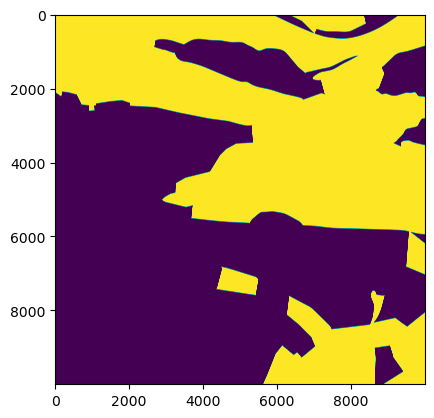

<AxesSubplot: >

In [18]:
# Quick plot of the forest mask
from rasterio.plot import show

show(trainmask)

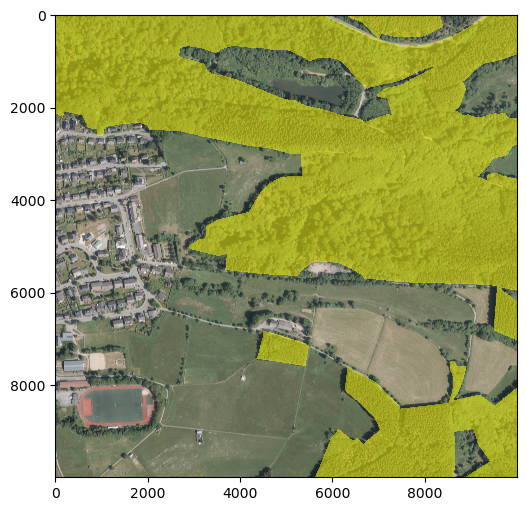

In [20]:
# Plot DOP (training area) with forest mask (only forest)
plt.figure(figsize=(10,6))
plt.imshow(np.array([dop_train.Band1, dop_train.Band2, dop_train.Band3]).transpose(1,2,0))
plt.imshow(np.where(dop_train.forest_mask==1,1,np.nan), cmap='autumn_r', interpolation='None', alpha=0.5)
plt.show()

In [21]:
# Write to disk
dop_train.to_netcdf('D:/COPY/Projekt_FF/Process/dop_train_forestmask.nc', mode='w')
dop_test.to_netcdf('D:/COPY/Projekt_FF/Process/dop_test_forestmask.nc', mode='w')